# GAN
## DCGAN 모델 구조 이용하여 CIFAR-10 데이터 생서어
- 이미지 데이터의 shape가 (28, 28, 1)에서 (32, 32, 3)으로 변경
- 이미지가 단색의 grayscale에서 RGB 3채널의 컬러이미지로 변경
- 입력데이터 전체 차원이 3~4배 증가하면서, 학습이 진행되는 양상이 다소 달라짐
---
### 0. 작업환경 구성하기

In [1]:
! mkdir -p ~/aiffel/dcgan_newimage/cifar10/generated_samples
! mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_checkpoints
! mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_history

In [3]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

### 1. 데이터셋 구성하기
- CIFAR-10 데이터셋도 tf.keras안에 있는 datasets에 포함되어 있음   


- 학습에 사용할 train_x의 이미지를 [-1, 1]로 정규화합니다.
- 로드한 학습 데이터를 시각화를 통해 확인해 봅시다.
- tf.data.Dataset 모듈의 fromtensorslices() 함수를 사용하여 미니배치 데이터셋을 구성해 봅시다.


In [4]:
# 데이터셋 불러오기 : tf.keras안에 있는 datasets 꺼내기 
cifar10 = tf.keras.datasets.cifar10

# 라벨 분류 필요없음 : _ 로 해당되는 데이터는 무시한다.
(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

170500096/170498071 [==============================] - 314s 2us/step


(50000, 32, 32, 3)

In [5]:
# 정규화

# Fashion MNIST 확인해보자 (0-255 사이의 픽셀값)
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

# -1, 1로 정규화 
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0
max pixel: 1.0
min pixel: -1.0


In [10]:
# 데이터셋 shape 확인 --  6만장 이미지가 28x28 사이즈

# CNN 채널 수 - 흑백은 1
train_x = train_x.reshape(train_x.shape[0], 32,32,3).astype('float32')
train_x.shape

(50000, 32, 32, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

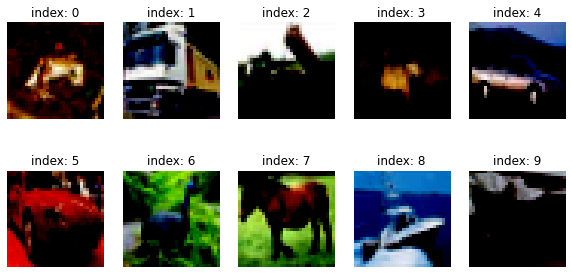

In [16]:
# 시각화
plt.figure(figsize=(10, 5))   # (10,5)는 이미지의 전체 프레임의 크기

# 여러 이미지 한번에 띄우기 plt.subplot(row, col, index)
for i in range(10):  
    plt.subplot(2, 5, i+1)  # 10개의 이미지를 2X5의 배열 형태
    plt.imshow(train_x[i],cmap='gray')
    plt.title(f'index: {i}')   # 이미지 제목으로 라벨값 넣어줌
    plt.axis('off')    # 불필요한 '축' 지우기
plt.show()

In [17]:
BUFFER_SIZE = 50000   # 전체 데이터를 섞기 위해 50,000으로 설정 
BATCH_SIZE = 256  # 미니배치 학습 = (모델이 한번에 학습할 데이터양)

In [18]:
# from_tensor_slices() 함수를 이용하여 리스트,넘파이,텐서플로우 텐서자료형 데이터셋 만들 수 있다.
# train_x라는 넘파이 배열형 자료를 섞고 배치사이즈에 따라 나누기 
# 잘 섞이게 하기 위해 버퍼사이즈 >= 총 데이터 사이즈 

train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

### 2. 생성자 모델 구현하기
- (32, 32, 3)의 shape를 가진 이미지를 생성하는 생성자 모델 구현 함수 작성
- noise = tf.random.normal([1, 100])로 생성된 랜덤 노이즈를 입력으로 하여 방금 구현한 생성자로 랜덤 이미지를 생성
- 생성된 랜덤 이미지가 생성자 출력 규격에 잘 맞는지 확인

In [21]:
# 생성자 생성 함수
def make_generator_model():

    # Start - 모델 시작하여 레이어 쌓기
    model = tf.keras.Sequential()  

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer - Conv2D와 반대로 이미지 사이즈 넓혀주는 층 
    # (8, 8, 256) → (16, 16, 64) → (32, 32, 1) 순으로 이미지를 키워나간다.
   
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())   # 신경망의 가중치가 폭발하지 않도록 가중치값을 정규화 시켜준다.
    model.add(layers.LeakyReLU()) # 활성화 함수

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(1, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh')) 
    # 활성화함수 tanh 사용 : -1 ~ 1 이내의 값으로 픽셀값을 정규화 시켰던 데이터셋과 동일하게 하기 위해

    return model

In [22]:
# 모델을 generator라는 변수로 생성 
generator = make_generator_model()
# 모델 세부 내용 summary 출력
generator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16384)             1638400   
_________________________________________________________________
batch_normalization_3 (Batch (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16384)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_4 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 128)        

Non_trainable params????????????

In [24]:
# shape=(1, 100)의 형상을 가지는 랜덤 노이즈 벡터를 생성
# tf.random.normal을 이용하면 가우시안 분포에서 뽑아낸 랜덤 벡터로 이루어진 노이즈 벡터를 만들 수 있다.

noise = tf.random.normal([1, 100])

In [25]:
# [1, 32,32, 1] 사이즈 이미지 생성됨
# 1 : batch_size = 1, (32,32,1) 사이즈 이미지 생성 되었다는 뜻

generated_image = generator(noise, training=False) # 학습 중이 아니다.
generated_image.shape

TensorShape([1, 32, 32, 1])

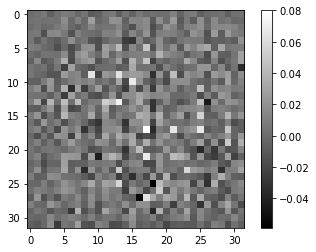

In [26]:
# 이미지 시각화 
# matplotlib는 2차원 이미지만 볼 수 있으므로, 0,3번째 축 인덱스를 0으로 설정
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.colorbar()
plt.show()
# 아직 모델 학습 전이라 노이즈가 보인다. 

### 3. 판별자 모델 구현하기
- (32, 32, 3)의 이미지를 입력으로 받아 1dim을 판별결과를 출력하는 판별자 모델 구현 함수를 작성해 봅시다.
- 위 STEP 2에서 생성한 랜덤 이미지를 판별자 모델이 판별한 결과값을 확인해 봅시다.


In [30]:
# 판별자 함수 구현
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer - 이미지의 크기를 줄여나간다.
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer - 3차원-> 1차원으로 펴서 8x8x128=8192, 즉 (1, 8192) 형상의 벡터로 변환
    # Reshape 층에서 1차원-> 3차원으로 변환했던 것과 반대 역할 
    model.add(layers.Flatten())

    # Fourth: Dense Layer - 단 하나의 값으로 출력
    model.add(layers.Dense(1))

    return model

In [31]:
# 모델 변수로 생성
discriminator = make_discriminator_model()
# 모델 세부 내용 출력
discriminator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        1664      
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)             

In [32]:
# 만약 가짜 이미지는 판별자에 입력 시키면 ?
decision = discriminator(generated_image, training=False)
decision
# 텐서플로우의 텐서 형태로 출력 - 아무 의미 없음 ~

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00090283]], dtype=float32)>

### 4. 손실함수와 최적화 함수 구현하기
